In [1]:
%%html
<style> table {float:left} </style>

In [2]:
import sqlite3
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pickle

pd.options.mode.chained_assignment = None

In [3]:
# only BF pretrained 

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

In [5]:
def semi_supervised_learning(train_data,valid_data,test_data,model,algorithm,threshold=0.8, iterations=40):
    print("Training "+algorithm+" Model")
    _train_labels = train_data['flagged']
    _train_data = train_data.drop(['flagged','reviewContent'], axis=1)
    _valid_labels = valid_data['flagged']
    _valid_data = valid_data.drop(['flagged','reviewContent'], axis=1)
    _test_labels = test_data['flagged']
    _test_data = test_data.drop(['flagged','reviewContent'], axis=1)

    all_labeled = False

    current_iteration = 0

    pbar = tqdm(total=iterations)

    while not all_labeled and (current_iteration < iterations):
        current_iteration += 1
        model.fit(_train_data, _train_labels)
        probabilities = model.predict_proba(_valid_data)
        pseudo_labels = model.predict(_valid_data)
        indices = np.argwhere(probabilities > threshold)
        for item in indices:
            _train_data.loc[_valid_data.index[item[0]]] = _valid_data.iloc[item[0]]
            _train_labels.loc[_valid_data.index[item[0]]] = pseudo_labels[item[0]]
        _valid_data.drop(_valid_data.index[indices[:, 0]], inplace=True)
        _valid_labels.drop(_valid_labels.index[indices[:, 0]], inplace=True)

        if len(_valid_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(_test_data)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('Accuracy Score : ' + str(accuracy_score(_test_labels, predicted_labels)))
    print('Precision Score : ' + str(precision_score(_test_labels, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(_test_labels, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(_test_labels, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(_test_labels, predicted_labels)))
    plot_confusion_matrix(_test_labels, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()
    
    return model

In [6]:
def supervised_learning(train_data,valid_data,test_data,model,algorithm,threshold=0.8, iterations=40):
    print("Training "+algorithm+" Model")
    _train_labels = train_data['flagged']
    _train_data = train_data.drop(['flagged','reviewContent'], axis=1)
    _valid_labels = valid_data['flagged']
    _valid_data = valid_data.drop(['flagged','reviewContent'], axis=1)
    _test_labels = test_data['flagged']
    _test_data = test_data.drop(['flagged','reviewContent'], axis=1)

    model.fit(_train_data, _train_labels)
    predicted_labels = model.predict(_test_data)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('Accuracy Score : ' + str(accuracy_score(_test_labels, predicted_labels)))
    print('Precision Score : ' + str(precision_score(_test_labels, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(_test_labels, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(_test_labels, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(_test_labels, predicted_labels)))
    plot_confusion_matrix(_test_labels, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()
    
    return model

### Pretrained

In [7]:
#with bf no sample

In [8]:
train_data = pd.read_csv("../data/pretrained_model/train_no_sampled.csv")
valid_data = pd.read_csv("../data/pretrained_model/valid_no_sampled.csv")
test_data = pd.read_csv("../data/pretrained_model/test_no_sampled.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.857911333704322
Precision Score : 0.7401415571284126
Recall Score : 0.5898468976631749
F1 Score : 0.6565022421524663
Confusion Matrix : 
[[3893  257]
 [ 509  732]]


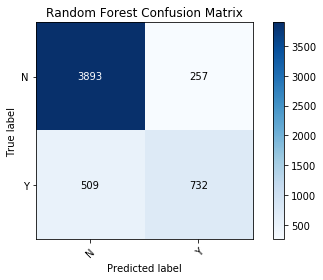

In [9]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.9,
                                 iterations=15, 
                                 algorithm='Random Forest')
with open('../models/semi_sl/random_forest_model_no_sample.pickle', 'wb') as f:
    pickle.dump(model, f)

In [10]:
with open('../models/semi_sl/random_forest_model_no_sample.pickle', 'wb') as f:
    pickle.dump(model, f)

In [11]:
#with bf

In [12]:
train_data = pd.read_csv("../data/pretrained_model/train.csv")
valid_data = pd.read_csv("../data/pretrained_model/valid.csv")
test_data = pd.read_csv("../data/pretrained_model/test.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7913188647746243
Precision Score : 0.526173285198556
Recall Score : 0.9395648670427075
F1 Score : 0.6745733294764247
Confusion Matrix : 
[[3100 1050]
 [  75 1166]]


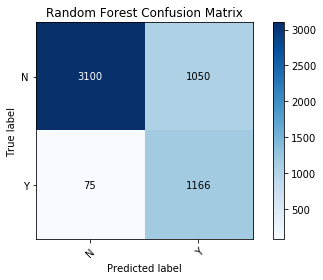

In [13]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=50, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=40, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_all.pickle', 'wb') as f:
    pickle.dump(model, f)

In [14]:
# only word2vec

In [15]:
train_data = pd.read_csv("../data/pretrained_model/train_no_bf.csv")
valid_data = pd.read_csv("../data/pretrained_model/valid_no_bf.csv")
test_data = pd.read_csv("../data/pretrained_model/test_no_bf.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7356705620478575
Precision Score : 0.4632
Recall Score : 0.9331184528605962
F1 Score : 0.6190858059342421
Confusion Matrix : 
[[2808 1342]
 [  83 1158]]


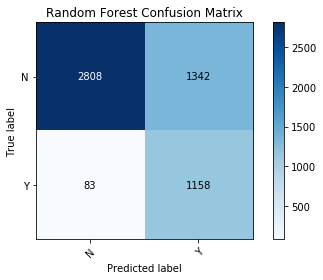

In [16]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=50, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=15, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_word2vec.pickle', 'wb') as f:
    pickle.dump(model, f)

In [17]:
# only bf

In [18]:
train_data = pd.read_csv("../data/pretrained_model/train_bf.csv")
valid_data = pd.read_csv("../data/pretrained_model/valid_bf.csv")
test_data = pd.read_csv("../data/pretrained_model/test_bf.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7918753478018921
Precision Score : 0.5266935845670704
Recall Score : 0.9460112812248187
F1 Score : 0.676657060518732
Confusion Matrix : 
[[3095 1055]
 [  67 1174]]


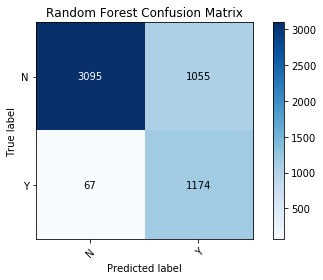

In [19]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=10, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=15, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_bf.pickle', 'wb') as f:
    pickle.dump(model, f)

### Self model

In [20]:
train_data = pd.read_csv("../data/self_model/train.csv")
valid_data = pd.read_csv("../data/self_model/valid.csv")
test_data = pd.read_csv("../data/self_model/test.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7781487664626229
Precision Score : 0.5097613882863341
Recall Score : 0.9468170829975826
F1 Score : 0.6627185561195714
Confusion Matrix : 
[[3020 1130]
 [  66 1175]]


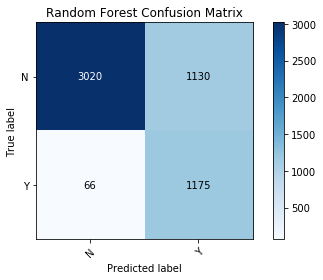

In [21]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=15, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_s_all.pickle', 'wb') as f:
    pickle.dump(model, f)

In [22]:
train_data = pd.read_csv("../data/self_model/train_no_bf.csv")
valid_data = pd.read_csv("../data/self_model/valid_no_bf.csv")
test_data = pd.read_csv("../data/self_model/test_no_bf.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7375255054720831
Precision Score : 0.46508828250401285
Recall Score : 0.9339242546333602
F1 Score : 0.6209482989552638
Confusion Matrix : 
[[2817 1333]
 [  82 1159]]


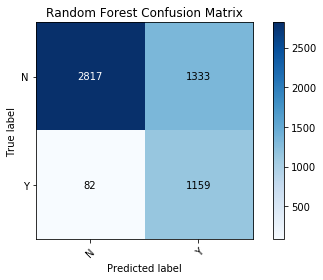

In [23]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=15, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_s_word2vec.pickle', 'wb') as f:
    pickle.dump(model, f)

In [24]:
train_data = pd.read_csv("../data/self_model/train_bf.csv")
valid_data = pd.read_csv("../data/self_model/valid_bf.csv")
test_data = pd.read_csv("../data/self_model/test_bf.csv")

Training Random Forest Model



Random Forest Model Results
Accuracy Score : 0.7868670005564831
Precision Score : 0.5201931518876207
Recall Score : 0.9548751007252216
F1 Score : 0.6734867860187553
Confusion Matrix : 
[[3057 1093]
 [  56 1185]]


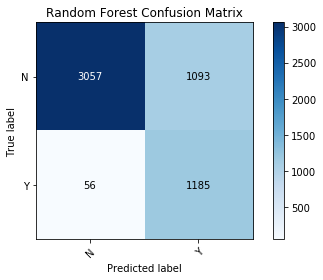

In [25]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                                n_estimators=500)

model = semi_supervised_learning(train_data,valid_data,test_data, model=rf, threshold=0.7,
                                 iterations=15, 
                                 algorithm='Random Forest')

with open('../models/semi_sl/random_forest_model_s_bf.pickle', 'wb') as f:
    pickle.dump(model, f)